> **Results from the best observation experiment.** 


# ⚙️ Set-up
Loads required packages and set seaborn as plotting style

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np

from helpers.paths import Path

sns.set()

Load data

In [2]:
# Load data
df_learn = pd.read_csv(Path.data/"citation-best-observation_learning.csv")
df_ep = pd.read_csv(Path.data/"citation-best-observation_episode.csv")


In [19]:
def make_smooth(_df, step=100, on=None, columns=None, group="run"):
    start = _df[on].min()
    stop = _df[on].max() + start
    info_list = []
    
    for run_name in _df[group].unique(): 
        # Get the name of the algorithm for the current run
        algorithm = _df.loc[_df[group]==run_name, "algorithm"].unique()[0]
        observation = _df.loc[_df[group]==run_name, "observation"].unique()[0]
        
        for t in np.arange(start, stop, step):
            mask = (_df[group]==run_name) & ((_df[on]>=t//2) & (_df[on]<t+step))
            run_slice = _df.loc[mask, columns]
            
            info = {"run": run_name, "step": t, "algorithm": algorithm, "observation": observation}
            for column in columns:
                info[column] = run_slice[column].mean()
                
            info_list.append(info)
     
    return pd.DataFrame.from_records(info_list)

In [20]:
df_learn_smooth = make_smooth(df_learn, step=100, on="global_step", columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"])

# 👨🏽‍🏫 Learning performance

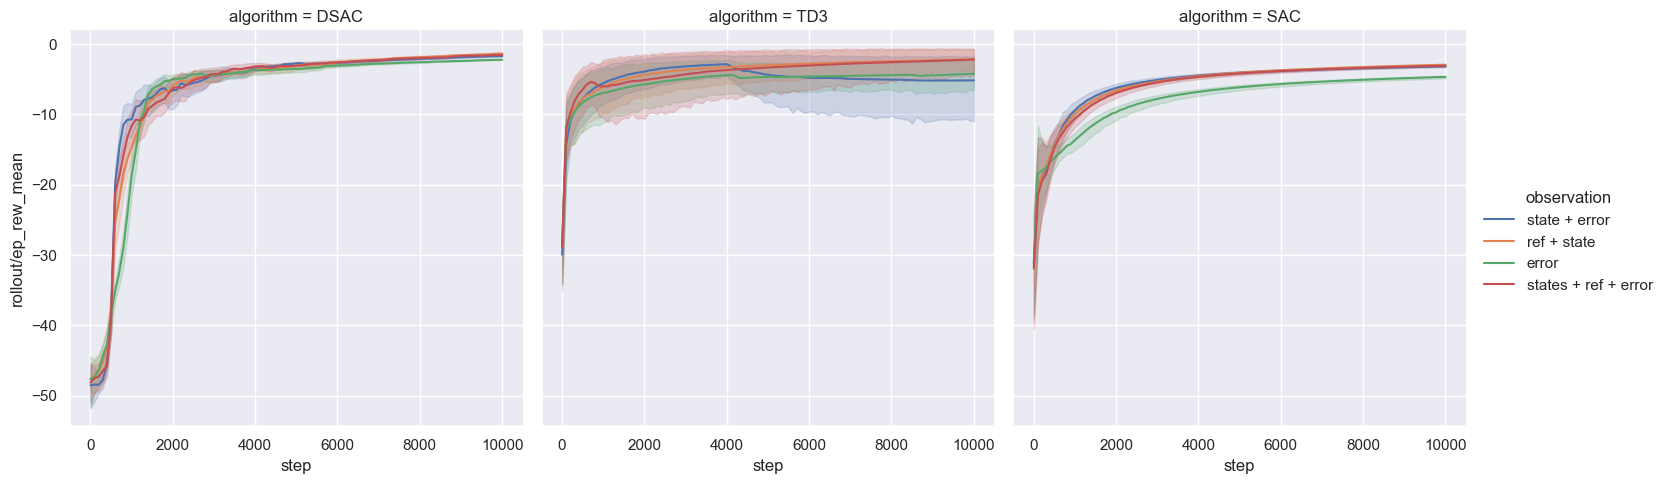

In [22]:
g = sns.relplot(data=df_learn_smooth, x="step", y="rollout/ep_rew_mean", hue="observation", kind="line", col="algorithm")

In [4]:
algorithm = "TD3"
df_ep_rew = df_ep.groupby(["run", "algorithm", "observation"])["reward"].sum().reset_index()
reward_count = df_ep_rew[df_ep_rew.algorithm==algorithm]["reward"].value_counts()
duplicated_rewards = reward_count[reward_count>1].index.values

df_ep_rew[df_ep_rew.reward.isin(duplicated_rewards)].groupby(["observation", "reward", "run"]).count()

,,,algorithm
observation,reward,run,
